In [23]:
!pip install tensorflow>=2.0.0
!pip install keras>=2.2.4-tf

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [24]:
import numpy as np
import pandas as pd
from glob import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [25]:
PATH_INPUT = "../input/vinbigdata-chest-xray-abnormalities-detection/"
df_labels=pd.read_csv(PATH_INPUT+"train.csv")
df_labels["path"]=df_labels.image_id.apply(lambda x: PATH_INPUT+f"train/{x}.dicom")
df_labels.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,path
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,../input/vinbigdata-chest-xray-abnormalities-d...
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,../input/vinbigdata-chest-xray-abnormalities-d...
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,../input/vinbigdata-chest-xray-abnormalities-d...
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,../input/vinbigdata-chest-xray-abnormalities-d...
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,../input/vinbigdata-chest-xray-abnormalities-d...


In [26]:
# Change class_id values
df_labels.class_id=df_labels.class_id+1
df_labels.loc[df_labels.class_id==15,"class_id"]=0

In [27]:
df_labels.class_name.value_counts()

No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: class_name, dtype: int64

In [28]:
df_labels.image_id.nunique()

15000

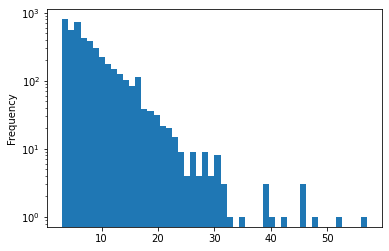

In [29]:
# Number of regions per image
df_labels.query("class_id!=0").image_id.value_counts().plot.hist(bins=50,log=True)

In [30]:
# Colormap
labels_info=df_labels.query("class_id!=0")[["class_id","class_name"]].drop_duplicates().sort_values(by="class_id").reset_index(drop=True)
labels_info["color"]=sns.color_palette("husl", labels_info.shape[0])
labels_info["color"]=labels_info["color"].apply(lambda x: tuple([int(cl*255) for cl in x]))
labels_info=labels_info.set_index("class_id",drop=True)
labels_info

,class_name,color
class_id,,
1,Aortic enlargement,"(246, 112, 136)"
2,Atelectasis,"(239, 124, 50)"
3,Calcification,"(197, 147, 49)"
4,Cardiomegaly,"(167, 158, 49)"
5,Consolidation,"(130, 168, 49)"
6,ILD,"(49, 178, 77)"
7,Infiltration,"(52, 175, 137)"
8,Lung Opacity,"(53, 172, 164)"
9,Nodule/Mass,"(55, 170, 186)"


In [31]:
## Reading a dicom file
# From: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from skimage import exposure
import cv2

def dicom2array(path, voi_lut=True, fix_monochrome=True, equalize_hist=False, clahe_normalization=False):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    
    # From: https://www.kaggle.com/raddar/popular-x-ray-image-normalization-techniques
    if equalize_hist:
        data = exposure.equalize_hist(data)
        
    if clahe_normalization:
        data = exposure.equalize_adapthist(data/np.max(data))
        
    return data

def plot_img(img, size=(7, 7), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()
    
def plot_img_with_labels(image_id,df_labels, labels_info, size=(7, 7), is_rgb=True, title="", cmap='gray'):
    df_plot = df_labels.query(f"image_id=='{image_id}'")
    img=dicom2array(df_plot.iloc[0].path)
    
    # To rgb:
    img=cv2.merge((img, img, img))
    # Draw boxes if present
    df_boxes = df_plot.query("class_id!=0")
    if df_boxes.shape[0]>0:
        for i,row in df_boxes.iterrows(): #x_min	y_min	x_max	y_max
            img = cv2.rectangle(img,(int(row.x_min), int(row.y_min)),(int(row.x_max), int(row.y_max)), labels_info.loc[row.class_id]["color"],5)
            
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

In [32]:
df_labels.query("image_id=='9a5094b2563a1ef3ff50dc5c7ff71345'")

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,path
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,4,R10,691.0,1375.0,1653.0,1831.0,../input/vinbigdata-chest-xray-abnormalities-d...
5517,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural effusion,11,R9,1789.0,1729.0,1875.0,1992.0,../input/vinbigdata-chest-xray-abnormalities-d...
25023,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural thickening,12,R9,1789.0,1729.0,1875.0,1992.0,../input/vinbigdata-chest-xray-abnormalities-d...
26165,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,4,R9,692.0,1375.0,1657.0,1799.0,../input/vinbigdata-chest-xray-abnormalities-d...
42709,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,4,R8,689.0,1313.0,1666.0,1763.0,../input/vinbigdata-chest-xray-abnormalities-d...
53473,9a5094b2563a1ef3ff50dc5c7ff71345,Aortic enlargement,1,R9,1052.0,715.0,1299.0,966.0,../input/vinbigdata-chest-xray-abnormalities-d...


/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (14-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "


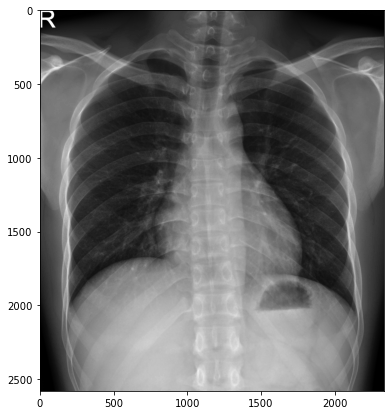

In [33]:
# No normalization
plot_img(dicom2array(df_labels.path.iloc[0]))

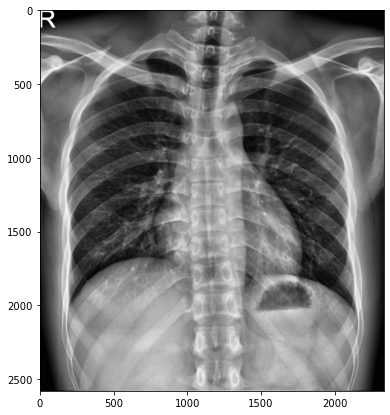

In [34]:
# Histogram normalization
plot_img(dicom2array(df_labels.path.iloc[0], clahe_normalization=True))

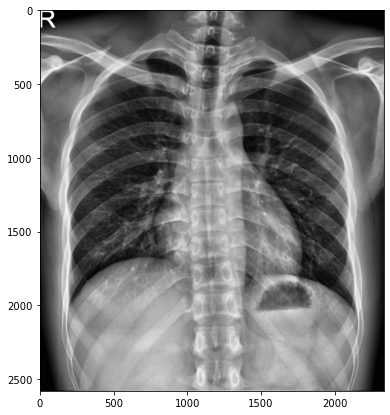

In [35]:
# CLAHE normalization
plot_img(dicom2array(df_labels.path.iloc[0], clahe_normalization=True))

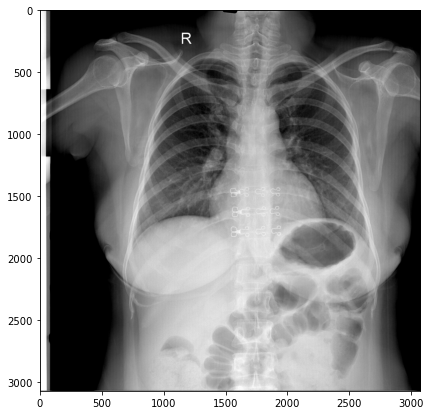

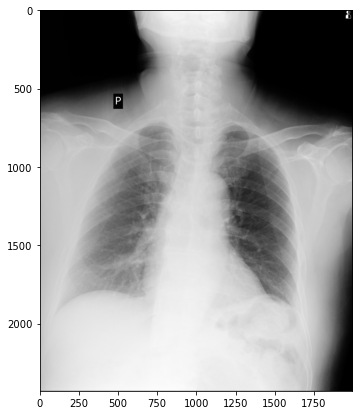

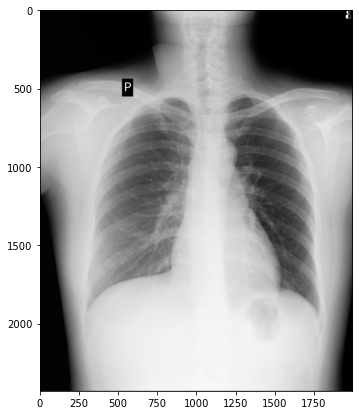

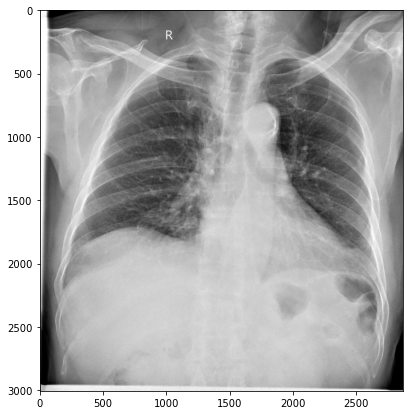

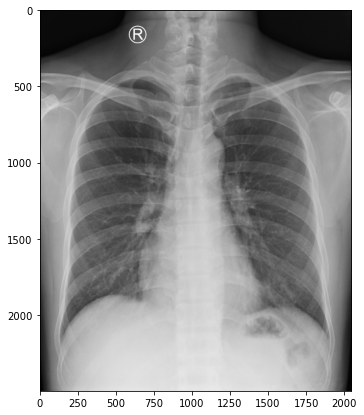

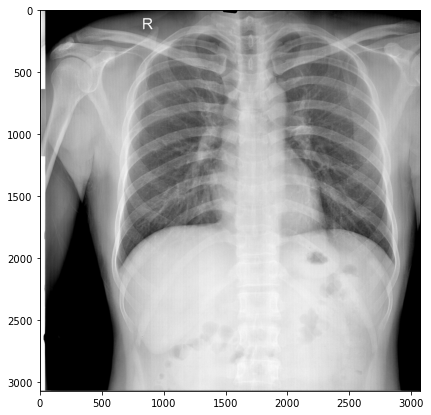

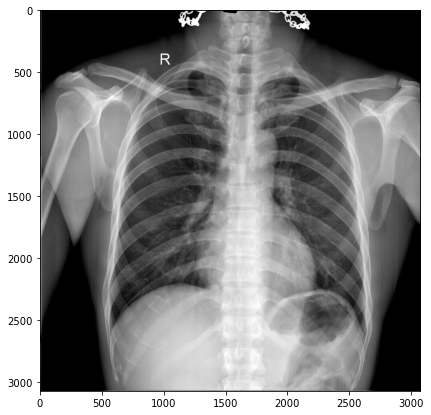

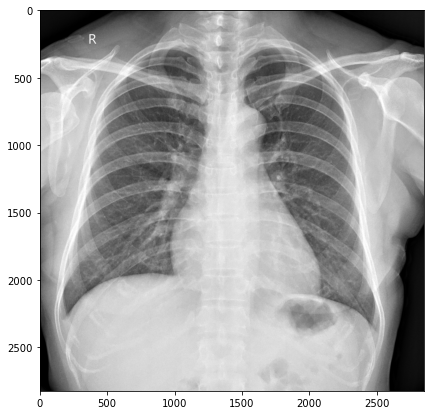

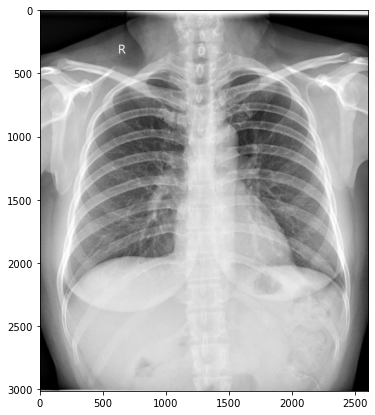

/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "


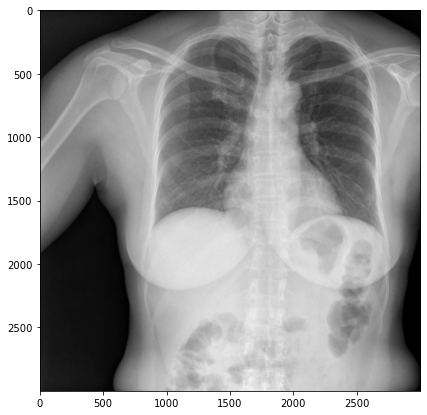

In [36]:
import random

for img_id in random.choices(df_labels.image_id.unique(),k=10):
    plot_img_with_labels(img_id,df_labels, labels_info)

In [37]:
path_example=df_labels.loc[0].path
print(path_example)
dicom2array(path_example)

../input/vinbigdata-chest-xray-abnormalities-detection/train/50a418190bc3fb1ef1633bf9678929b3.dicom


array([[255, 255, 255, ...,   1,   1,   1],
       [255, 255, 255, ...,   1,   1,   1],
       [255, 255, 255, ...,   1,   1,   1],
       ...,
       [  1,   1,   1, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0]], dtype=uint8)

In [39]:
# Generate images in png format
imgs_to_process=df_labels.image_id.unique()

#input_paths = [f"../input/vinbigdata-chest-xray-abnormalities-detection/train/{x}.dicom" for x in imgs_to_process] 
#os.mkdir("./preprocessed/")
#output_paths= [f"./preprocessed/{x}.png" for x in imgs_to_process]


#for inp,out in tqdm(zip(input_paths,output_paths)):
    

In [40]:
# Train / test split
# As a first approach, lets use train and test split (using test also for validation)
# TODO: Use Train / Validation / Test or kFold

df_labels.head()


random.seed(10)
random.shuffle(imgs_to_process)

perc=0.8
train_ids, test_ids=imgs_to_process[:int(len(imgs_to_process)*perc)],imgs_to_process[int(len(imgs_to_process)*perc):]

df_labels["split"]="test"
df_labels.loc[df_labels.image_id.isin(train_ids),"split"]="train"

df_train, df_test = df_labels.query("split=='train'"),df_labels.query("split=='test'")

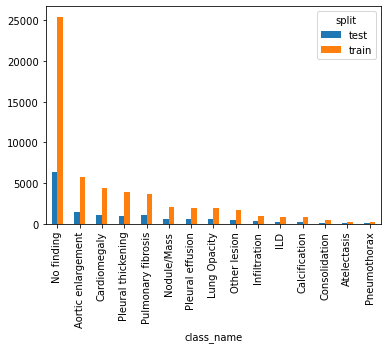

In [41]:
df_labels.groupby(["split"]).class_name.value_counts().unstack().T.sort_values(by="train",ascending=False).plot.bar()

In [42]:
df_train.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,path,split
0,50a418190bc3fb1ef1633bf9678929b3,No finding,0,R11,NaN,NaN,NaN,NaN,../input/vinbigdata-chest-xray-abnormalities-d...,train
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,0,R7,NaN,NaN,NaN,NaN,../input/vinbigdata-chest-xray-abnormalities-d...,train
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,4,R10,691.0,1375.0,1653.0,1831.0,../input/vinbigdata-chest-xray-abnormalities-d...,train
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,1,R10,1264.0,743.0,1611.0,1019.0,../input/vinbigdata-chest-xray-abnormalities-d...,train
4,063319de25ce7edb9b1c6b8881290140,No finding,0,R10,NaN,NaN,NaN,NaN,../input/vinbigdata-chest-xray-abnormalities-d...,train


In [43]:
df_test.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,path,split
9,afb6230703512afc370f236e8fe98806,Pulmonary fibrosis,14,R9,1857.0,1607.0,2126.0,2036.0,../input/vinbigdata-chest-xray-abnormalities-d...,test
12,5550a493b1c4554da469a072fdfab974,No finding,0,R9,NaN,NaN,NaN,NaN,../input/vinbigdata-chest-xray-abnormalities-d...,test
18,5da264775732004f1b724b660138854a,Aortic enlargement,1,R9,1635.0,673.0,1978.0,1151.0,../input/vinbigdata-chest-xray-abnormalities-d...,test
40,8e063eadea9a6aeb684c893c8598be3e,Nodule/Mass,9,R10,376.0,1867.0,438.0,1914.0,../input/vinbigdata-chest-xray-abnormalities-d...,test
46,d86c7405606f965ab7300ef1eacbcacc,No finding,0,R4,NaN,NaN,NaN,NaN,../input/vinbigdata-chest-xray-abnormalities-d...,test


In [44]:
%%bash
git clone https://github.com/ahmedfgad/Mask-RCNN-TF2.git
mv -f Mask-RCNN-TF2/* .
rm -rf Mask-RCNN-TF2

Cloning into 'Mask-RCNN-TF2'...
mv: cannot move 'Mask-RCNN-TF2/assets' to './assets': Directory not empty
mv: cannot move 'Mask-RCNN-TF2/images' to './images': Directory not empty
mv: cannot move 'Mask-RCNN-TF2/kangaroo-transfer-learning' to './kangaroo-transfer-learning': Directory not empty
mv: cannot move 'Mask-RCNN-TF2/mrcnn' to './mrcnn': Directory not empty
mv: cannot move 'Mask-RCNN-TF2/samples' to './samples': Directory not empty


In [45]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

ROOT_DIR="./"
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

In [ ]:
class XrayConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    NAME = "xray"
    BACKBONE = "resnet50" # "resnet50"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    NUM_CLASSES = 1 + labels_info.shape[0]  # background + labels

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = int(df_train.shape[0]/IMAGES_PER_GPU)

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = int(df_test.shape[0]/IMAGES_PER_GPU)
    
config = XrayConfig()
config.display()

In [ ]:
# Functions to format the data for the MaskRCNN model: https://www.kaggle.com/frlemarchand/maskrcnn-for-chest-x-ray-anomaly-detection

def get_mask(img_dimensions, x_min, y_min, x_max, y_max):
    """ Return mask format for RCNN
    Given a x_min, y_min, x_max, y_max segmentation (object detection type) returns a mask
    """
    img_height, img_width = img_dimensions
    img_mask = np.full((img_height,img_width),0) # Initialize the an image with same size as original image with zeros
    img_mask[y_min:y_max,x_min:x_max] = 255 # Fill the object area with 255 values
    
    return img_mask.astype(np.float32)


def rle_encoding(x):
    dots = np.where(x.T.flatten() == 255)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join([str(x) for x in run_lengths])


def get_image_labels(df,dicom_folder, resized_folder, image_size=512):
    diagnostic_per_image = []

    for image_id in tqdm(df.image_id.unique()):
        #image_id = row.image_id
        image_df = df.query(f"image_id=='{image_id}'").query("class_id!=0") # Select all rows for an image id
        class_list = []
        RLE_list = []
        
        # Load image
        dicom_image = dicom2array(dicom_folder+image_id+".dicom", clahe_normalization=True)
        image_dimensions = dicom_image.shape
        
        # Resize and save image
        resized_img = cv2.resize(dicom_image, (image_size,image_size), interpolation = cv2.INTER_AREA)
        cv2.imwrite(resized_folder+image_id+".jpg", resized_img) 
        
        if image_df.shape[0]==0: # No annotations in the image
            class_list.append(0)
            mask = np.full(image_dimensions,0).astype(np.float32)
            resized_mask = cv2.resize(mask, (image_size,image_size))
            RLE_list.append(rle_encoding(resized_mask))
            
        else:
            for diagnostic_id, diagnostic in image_df.iterrows(): # For each annotation...
                class_list.append(diagnostic.class_id)

                mask = get_mask(image_dimensions, int(diagnostic.x_min), int(diagnostic.y_min), int(diagnostic.x_max), int(diagnostic.y_max))
                resized_mask = cv2.resize(mask, (image_size,image_size))
                RLE_list.append(rle_encoding(resized_mask))
                
        diagnostic_per_image.append({"image_id":image_id,
                                     "CategoryId":class_list,
                                     "EncodedPixels":RLE_list})
        
    samples_df = pd.DataFrame(diagnostic_per_image)
    samples_df["Height"] = image_size
    samples_df["Width"] = image_size
    return samples_df

In [ ]:
def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        
PATH_RESIZED="./resized/"
        
mkdir(PATH_RESIZED)


!gsutil -m cp -r gs://vinbigdatadaruai/* $PATH_RESIZED   

In [ ]:
# Load train and test dataset
df_train_info=pd.read_csv(PATH_RESIZED+"df_train_info.csv")
df_test_info=pd.read_csv(PATH_RESIZED+"df_test_info.csv")

df_train_info.head()

In [ ]:
# From (with some modifications): https://www.kaggle.com/frlemarchand/maskrcnn-for-chest-x-ray-anomaly-detection
import ast
class XrayDataset(utils.Dataset):
    def __init__(self, df, labels_info,IMAGE_SIZE=512):
        super().__init__(self)
        
        # Add classes
        for i, row in labels_info.iterrows():
            self.add_class("diagnostic", row.name, row.class_name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("diagnostic", 
                           image_id=row.name,
                           path=PATH_RESIZED+"resized/"+str(row.image_id)+".jpg", 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])
        self.IMAGE_SIZE=IMAGE_SIZE

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [category_list[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return cv2.imread(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        info['annotations']=ast.literal_eval(info['annotations'])
        info['labels']=ast.literal_eval(info['labels'])
                
        mask = np.zeros((self.IMAGE_SIZE, self.IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            
            if label!=0:
                annotation = [int(x) for x in annotation.split(' ')]
                for i, start_pixel in enumerate(annotation[::2]):
                    sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1


            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (self.IMAGE_SIZE, self.IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            mask[:, :, m] = sub_mask
            labels.append(int(label))
        return mask, np.array(labels)

In [ ]:
train_dataset = XrayDataset(df_train_info,labels_info)
train_dataset.prepare()

valid_dataset = XrayDataset(df_test_info,labels_info)
valid_dataset.prepare()

for i in range(10):
    image_id = random.choice(train_dataset.image_ids)
    image = train_dataset.load_image(image_id)
    mask, class_ids = train_dataset.load_mask(image_id)
    
    visualize.display_top_masks(image, mask, class_ids, train_dataset.class_names, limit=5)

In [ ]:
LR = 1e-4
EPOCHS = [1,18]

model = modellib.MaskRCNN(mode='training', config=config, model_dir="")
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

In [ ]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR,
            epochs=EPOCHS[0],
            layers='heads')

history = model.keras_model.history.history

In [ ]:
epochs = range(EPOCHS[-1])

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()